# SCI6485 Introduction to Generative Artificial Intelligence

##  Building a GAN from scratch


**Harvard University**<br/>
**Fall 2023**<br/>
**Instructor:**  Sabrina Osmany<br/>
**TA:**  Jiabin Wei<br/>

**DISCLAIMER**: No public reproduction of this code is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---

This tutorial is heavily borrowed from this github [repo](https://github.com/diegoalejogm/gans).

In [2]:
from IPython import display
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# Load Data

In [3]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

batch_size=64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

100%|██████████| 9912422/9912422 [00:00<00:00, 172363847.30it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 32021066.30it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40905249.25it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 928840.99it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



torch.Size([64, 1, 28, 28])


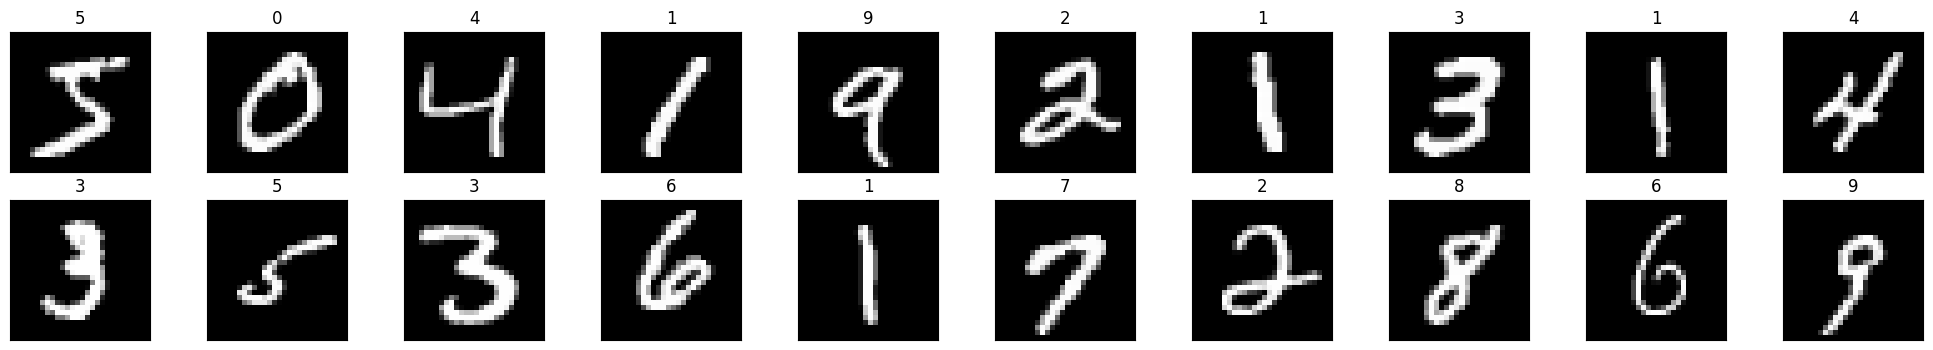

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def im_convert(img):
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    return image

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# check batch size
print(images.shape)

# show images
fig = plt.figure(figsize=(25, 4))
# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]), cmap='gray') #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

# Vanilla GAN architecture

In [5]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

def images_to_vectors(images):
    # flatten the image data to a linear layer
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    # conver a flattened image back to a 2d image
    return vectors.view(vectors.size(0), 1, 28, 28)

In [6]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        # the output shape is (batch_size, 1, 784). we later convert it to a (batch_size, 1, 28, 28) tensor when generating new images.
        x = self.out(x)
        return x

# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    n.to(device)
    return n

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

discriminator = DiscriminatorNet()
generator = GeneratorNet()

discriminator.to(device)
generator.to(device)


Selected device: cpu


GeneratorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

# Optimization and loss function

In [8]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()


# Training

In [9]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    data.to(device)
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    for fake
    '''
    data = Variable(torch.zeros(size, 1))
    data.to(device)
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()

    # 1.3 Update weights with gradients
    optimizer.step()

    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [12]:
# generate some images during the training process
num_test_samples = 16
test_noise = noise(num_test_samples)
generated_noise = vectors_to_images(generator(test_noise)).data.cpu()

In [13]:
# Create a figure and axes to display the images
def show_image(generated_images, num_test_samples):
    fig, axes = plt.subplots(1, num_test_samples, figsize=(20, 20))
    axes = axes.ravel()

    for i in range(num_test_samples):
        axes[i].imshow(im_convert(generated_images[i]), cmap='gray')
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

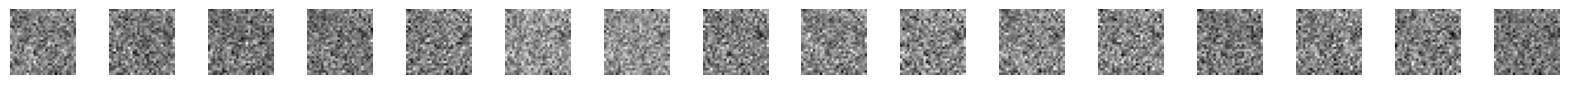

In [14]:
show_image(generated_noise, num_test_samples)

### Start training

In [15]:
# Number of steps to apply to the discriminator
# In Goodfellow et. al 2014 this variable is assigned to 1
d_steps = 1
# Number of epochs
num_epochs = 10

In [16]:
d_error_history = []
g_error_history = []

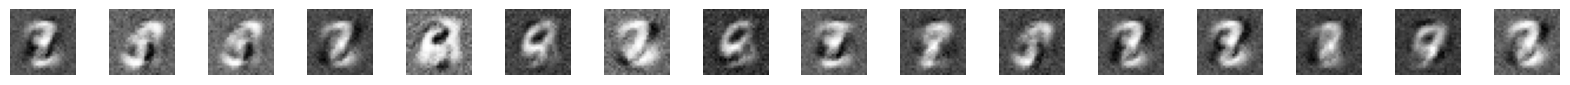

In [ ]:
for epoch in range(num_epochs):
    d_error_epoch = 0
    g_error_epoch = 0

    for n_batch, (real_batch,_) in enumerate(train_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        real_data.to(device)

        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Log error
        d_error_epoch += d_error
        g_error_epoch += g_error

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            show_image(test_images, num_test_samples)

    d_error_history.append(d_error_epoch)
    g_error_history.append(g_error_epoch)
    print('epoch: {}  discriminator error: {}   generator error: {}'.format(epoch, d_error_epoch, g_error_epoch))

# Generate new images

In [ ]:
# generate 10 new images
new_samples = 10
test_noise = noise(new_samples)

test_images = vectors_to_images(generator(test_noise)).data.cpu()
show_image(test_images, new_samples)
